Importing Libraries


In [11]:
# Data manipulation
import pandas as pd
# Numerical operations
import numpy as np
# Data splitting and cross-validation
from sklearn.model_selection import train_test_split, StratifiedKFold
# Categorical label encoding
from sklearn.preprocessing import LabelEncoder
# Classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Deep learning framework
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# Word2Vec word embeddings
from gensim.models import Word2Vec
# Random number generation
import random
# Natural Language Toolkit
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
# Data visualization
import matplotlib.pyplot as plt
# Progress bar
from tqdm import tqdm
# Regular expressions
import re
# Pre-trained transformer models
from transformers import BertTokenizer, BertForSequenceClassification, AdamW





In [12]:
nltk.download('stopwords')  # Download stopwords list used in text preprocessing
nltk.download('wordnet')     # Download WordNet lexical database for lemmatization
nltk.download('punkt')       # Download the Punkt tokenizer models for tokenization


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\khans\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\khans\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\khans\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
train_df = pd.read_csv('train.csv')

# Count the occurrences of each label
label_counts = train_df['label'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color='blue')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.xticks(label_counts.index)
plt.show()








KeyError: 'label'

Epoch 1/50, Validation Accuracy: 0.6425, Validation Precision: 0.6505, Validation Recall: 0.6425, Validation F1 Score: 0.6364
Epoch 2/50, Validation Accuracy: 0.6603, Validation Precision: 0.6699, Validation Recall: 0.6603, Validation F1 Score: 0.6542
Epoch 3/50, Validation Accuracy: 0.6727, Validation Precision: 0.6793, Validation Recall: 0.6727, Validation F1 Score: 0.6671
Epoch 4/50, Validation Accuracy: 0.6853, Validation Precision: 0.6913, Validation Recall: 0.6853, Validation F1 Score: 0.6805
Epoch 5/50, Validation Accuracy: 0.6955, Validation Precision: 0.7014, Validation Recall: 0.6955, Validation F1 Score: 0.6914
Epoch 6/50, Validation Accuracy: 0.7060, Validation Precision: 0.7111, Validation Recall: 0.7060, Validation F1 Score: 0.7027
Epoch 7/50, Validation Accuracy: 0.7180, Validation Precision: 0.7230, Validation Recall: 0.7180, Validation F1 Score: 0.7154
Epoch 8/50, Validation Accuracy: 0.7280, Validation Precision: 0.7336, Validation Recall: 0.7280, Validation F1 Score:

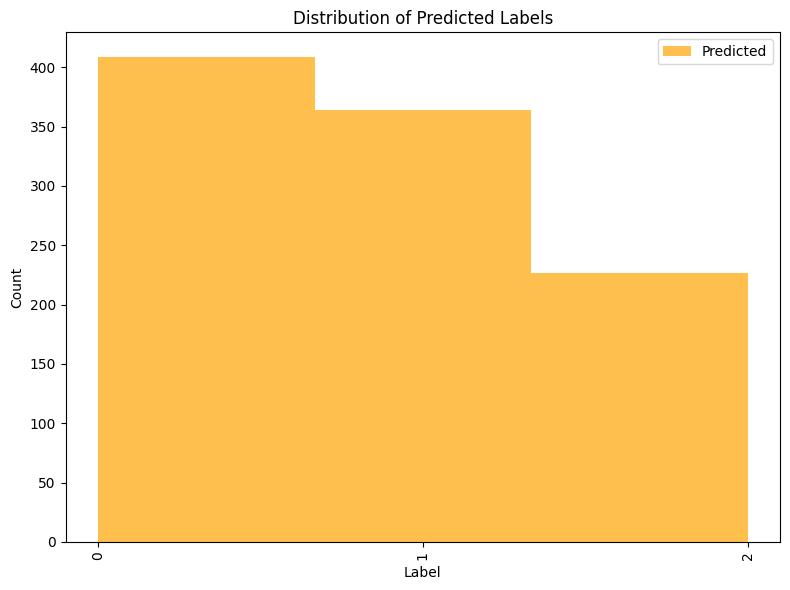

In [ ]:

# Load and preprocess data
train_df = pd.read_csv('train.csv', usecols=['text', 'aspect', 'label'])
test_df = pd.read_csv('test.csv', usecols=['text', 'aspect'])

# Define data augmentation functions
def random_insertion(words, n):
    for _ in range(n):
        random_word = random.choice(words)
        words.insert(random.randint(0, len(words)), random_word)
    return words

# Apply data augmentation
num_augmentations = 9
augmented_data = []
for _, row in train_df.iterrows():
    original_text = row['text']
    words = word_tokenize(original_text)

    augmented_texts = []
    for _ in range(num_augmentations):
        augmented_words = random_insertion(words.copy(), n=random.randint(1, 3))
        augmented_texts.append(' '.join(augmented_words))

    for augmented_text in augmented_texts:
        augmented_data.append({'text': augmented_text, 'aspect': row['aspect'], 'label': row['label']})

# Convert augmented data to a DataFrame
augmented_df = pd.DataFrame(augmented_data)

# Concatenate the original and augmented data
expanded_train_df = pd.concat([train_df, augmented_df], ignore_index=True)

# Shuffle the dataset
expanded_train_df = expanded_train_df.sample(frac=1).reset_index(drop=True)

# Split train dataset into train and validation sets
train_df, val_df = train_test_split(expanded_train_df, test_size=0.1, random_state=42)

# Train Word2Vec embeddings
sentences = [text.split() + ['Aspect:' + aspect] for text, aspect in zip(train_df['text'], train_df['aspect'])]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.save('word2vec_model.model')

# Convert labels to numerical values
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['label'])
val_df['label'] = label_encoder.transform(val_df['label'])

# Convert data to embeddings
def text_to_embeddings(text, aspect):
    tokens = text.split() + ['Aspect:' + aspect]
    embeddings = [word2vec_model.wv[token] for token in tokens if token in word2vec_model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)  # Use zero vectors for empty embeddings

train_embeddings = np.array([text_to_embeddings(text, aspect) for text, aspect in zip(train_df['text'], train_df['aspect'])])
val_embeddings = np.array([text_to_embeddings(text, aspect) for text, aspect in zip(val_df['text'], val_df['aspect'])])
test_embeddings = np.array([text_to_embeddings(text, aspect) for text, aspect in zip(test_df['text'], test_df['aspect'])])

# Define a simple neural network model
class SentimentModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SentimentModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training configuration
input_dim = train_embeddings.shape[1]
hidden_dim = 1024
output_dim = len(label_encoder.classes_)
model = SentimentModel(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

# Convert embeddings and labels to PyTorch tensors
train_embeddings = torch.tensor(train_embeddings, dtype=torch.float32)
train_labels = torch.tensor(train_df['label'].values, dtype=torch.long)
val_embeddings = torch.tensor(val_embeddings, dtype=torch.float32)
val_labels = torch.tensor(val_df['label'].values, dtype=torch.long)
test_embeddings = torch.tensor(test_embeddings, dtype=torch.float32)

# Training loop
num_epochs = 50
batch_size = 1000
for epoch in range(num_epochs):
    model.train()
    for batch_start in range(0, len(train_embeddings), batch_size):
        batch_end = batch_start + batch_size
        batch_embeddings = train_embeddings[batch_start:batch_end]
        batch_labels = train_labels[batch_start:batch_end]

        optimizer.zero_grad()
        outputs = model(batch_embeddings)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_outputs = model(val_embeddings)
    val_predictions = torch.argmax(val_outputs, dim=1)
    val_accuracy = torch.sum(val_predictions == val_labels).item() / len(val_labels)

    # Calculate precision, recall, and F1 score for validation data
    val_precision = precision_score(val_labels, val_predictions, average='weighted')
    val_recall = recall_score(val_labels, val_predictions, average='weighted')
    val_f1 = f1_score(val_labels, val_predictions, average='weighted')

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {val_accuracy:.4f}, "
          f"Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}, "
          f"Validation F1 Score: {val_f1:.4f}")

# Inference on test data
model.eval()
test_outputs = model(test_embeddings)
test_predictions = torch.argmax(test_outputs, dim=1)
test_labels = test_predictions.numpy()

# Plot distribution of predicted labels
plt.figure(figsize=(8, 6))
plt.hist(label_encoder.inverse_transform(test_labels), bins=len(label_encoder.classes_), alpha=0.7, color='orange', label='Predicted')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Predicted Labels')
plt.xticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_, rotation='vertical')
plt.legend()
plt.tight_layout()
plt.show()


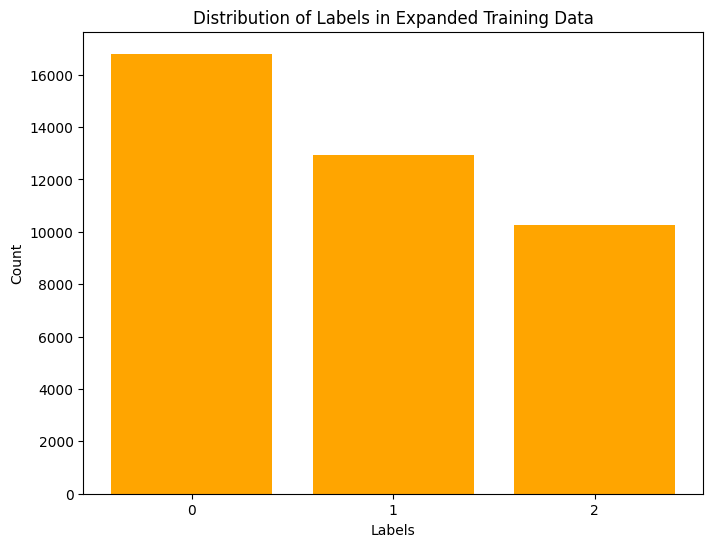

In [ ]:
label_counts = expanded_train_df['label'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color='orange')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels in Expanded Training Data')
plt.xticks(label_counts.index)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec
import random
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

# Load and preprocess data
train_df = pd.read_csv('train.csv', usecols=['text', 'aspect', 'label'])
test_df = pd.read_csv('test.csv', usecols=['text', 'aspect'])

# Define data augmentation functions
def random_insertion(words, n):
    for _ in range(n):
        random_word = random.choice(words)
        words.insert(random.randint(0, len(words)), random_word)
    return words

# Apply data augmentation
num_augmentations = 9
augmented_data = []
for _, row in train_df.iterrows():
    original_text = row['text']
    words = word_tokenize(original_text)

    augmented_texts = []
    for _ in range(num_augmentations):
        augmented_words = random_insertion(words.copy(), n=random.randint(1, 3))
        augmented_texts.append(' '.join(augmented_words))

    for augmented_text in augmented_texts:
        augmented_data.append({'text': augmented_text, 'aspect': row['aspect'], 'label': row['label']})

# Convert augmented data to a DataFrame
augmented_df = pd.DataFrame(augmented_data)

# Concatenate the original and augmented data
expanded_train_df = pd.concat([train_df, augmented_df], ignore_index=True)

# Shuffle the dataset
expanded_train_df = expanded_train_df.sample(frac=1).reset_index(drop=True)

# Split train dataset into train and validation sets
train_df, val_df = train_test_split(expanded_train_df, test_size=0.1, random_state=42)

# Train Word2Vec embeddings
sentences = [text.split() + ['Aspect:' + aspect] for text, aspect in zip(train_df['text'], train_df['aspect'])]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.save('word2vec_model.model')

# Convert labels to numerical values
sentiment_label_encoder = LabelEncoder()

train_df['label'] = sentiment_label_encoder.fit_transform(train_df['label'])
val_df['label'] = sentiment_label_encoder.transform(val_df['label'])

# Convert aspect labels to numerical values using a dictionary
aspect_label_mapping = {label: idx for idx, label in enumerate(train_df['aspect'].unique())}

train_df['aspect_label'] = train_df['aspect'].map(aspect_label_mapping)
val_df['aspect_label'] = val_df['aspect'].map(aspect_label_mapping)
test_df['aspect_label'] = test_df['aspect'].map(aspect_label_mapping)

# Convert data to embeddings
def text_to_embeddings(text, aspect):
    tokens = text.split() + ['Aspect:' + aspect]
    embeddings = [word2vec_model.wv[token] for token in tokens if token in word2vec_model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)  # Use zero vectors for empty embeddings

train_embeddings = np.array([text_to_embeddings(text, aspect) for text, aspect in zip(train_df['text'], train_df['aspect'])])
val_embeddings = np.array([text_to_embeddings(text, aspect) for text, aspect in zip(val_df['text'], val_df['aspect'])])
test_embeddings = np.array([text_to_embeddings(text, aspect) for text, aspect in zip(test_df['text'], test_df['aspect'])])

# Define a simple neural network model
class SentimentAspectModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SentimentAspectModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_sentiment = nn.Linear(hidden_dim, output_dim)
        self.fc2_aspect = nn.Linear(hidden_dim, len(aspect_label_mapping))

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        sentiment_output = self.fc2_sentiment(x)
        aspect_output = self.fc2_aspect(x)
        return sentiment_output, aspect_output

# Training configuration
input_dim = train_embeddings.shape[1]
hidden_dim = 1024
output_dim = len(sentiment_label_encoder.classes_)

# Initialize the model
model = SentimentAspectModel(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

# Convert embeddings and labels to PyTorch tensors
train_embeddings = torch.tensor(train_embeddings, dtype=torch.float32)
train_sentiment_labels = torch.tensor(train_df['label'].values, dtype=torch.long)
train_aspect_labels = torch.tensor(train_df['aspect_label'].values, dtype=torch.long)

val_embeddings = torch.tensor(val_embeddings, dtype=torch.float32)
val_sentiment_labels = torch.tensor(val_df['label'].values, dtype=torch.long)
val_aspect_labels = torch.tensor(val_df['aspect_label'].values, dtype=torch.long)

test_embeddings = torch.tensor(test_embeddings, dtype=torch.float32)

# Training loop
num_epochs = 50
batch_size = 1000
for epoch in range(num_epochs):
    model.train()
    for batch_start in range(0, len(train_embeddings), batch_size):
        batch_end = batch_start + batch_size
        batch_embeddings = train_embeddings[batch_start:batch_end]
        batch_sentiment_labels = train_sentiment_labels[batch_start:batch_end]
        batch_aspect_labels = train_aspect_labels[batch_start:batch_end]

        optimizer.zero_grad()
        sentiment_outputs, aspect_outputs = model(batch_embeddings)
        sentiment_loss = criterion(sentiment_outputs, batch_sentiment_labels)
        aspect_loss = criterion(aspect_outputs, batch_aspect_labels)
        total_loss = sentiment_loss + aspect_loss
        total_loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_sentiment_outputs, val_aspect_outputs = model(val_embeddings)
    val_sentiment_predictions = torch.argmax(val_sentiment_outputs, dim=1)
    val_aspect_predictions = torch.argmax(val_aspect_outputs, dim=1)

    sentiment_accuracy = accuracy_score(val_sentiment_labels, val_sentiment_predictions)
    aspect_accuracy = accuracy_score(val_aspect_labels, val_aspect_predictions)

    print(f"Epoch {epoch+1}/{num_epochs}, Sentiment Accuracy: {sentiment_accuracy:.4f}, Aspect Accuracy: {aspect_accuracy:.4f}")

# Inference on test data
model.eval()
test_sentiment_outputs, test_aspect_outputs = model(test_embeddings)
test_sentiment_predictions = torch.argmax(test_sentiment_outputs, dim=1)
test_aspect_predictions = torch.argmax(test_aspect_outputs, dim=1)

# Convert encoded aspect labels back to original labels
# Map aspect label predictions back to original labels
test_aspect_predictions_labels = [label for idx in test_aspect_predictions.numpy() for label, label_idx in aspect_label_mapping.items() if label_idx == idx]



ValueError: Usecols do not match columns, columns expected but not found: ['label', 'text', 'aspect']

Test Aspect Accuracy: 0.2510


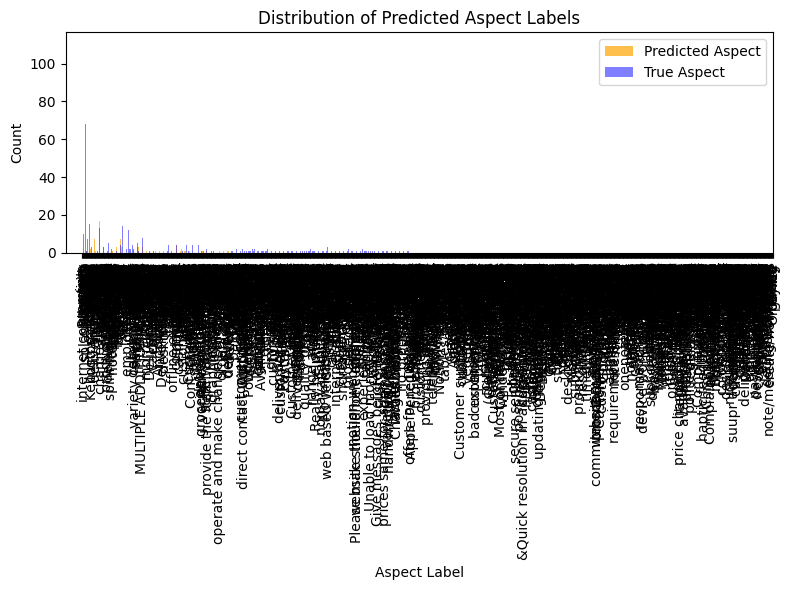

In [ ]:
from sklearn.metrics import accuracy_score

# Calculate accuracy for aspect predictions
test_aspect_accuracy = accuracy_score(test_aspect_predictions_labels, test_df['aspect'])

print(f"Test Aspect Accuracy: {test_aspect_accuracy:.4f}")


plt.figure(figsize=(8, 6))
plt.hist(test_aspect_predictions_labels, bins=len(aspect_label_mapping), alpha=0.7, color='orange', label='Predicted Aspect')
plt.hist(test_df['aspect'], bins=len(aspect_label_mapping), alpha=0.5, color='blue', label='True Aspect')
plt.xlabel('Aspect Label')
plt.ylabel('Count')
plt.title('Distribution of Predicted Aspect Labels')
plt.xticks(np.arange(len(aspect_label_mapping)), aspect_label_mapping.keys(), rotation='vertical')
plt.legend()
plt.tight_layout()
plt.show()


Fold 1/5
Epoch 1/50, Validation Accuracy: 0.6261, Validation Precision: 0.6275, Validation Recall: 0.6261, Validation F1 Score: 0.6196
Epoch 2/50, Validation Accuracy: 0.6359, Validation Precision: 0.6379, Validation Recall: 0.6359, Validation F1 Score: 0.6309
Epoch 3/50, Validation Accuracy: 0.6459, Validation Precision: 0.6479, Validation Recall: 0.6459, Validation F1 Score: 0.6417
Epoch 4/50, Validation Accuracy: 0.6565, Validation Precision: 0.6572, Validation Recall: 0.6565, Validation F1 Score: 0.6527
Epoch 5/50, Validation Accuracy: 0.6631, Validation Precision: 0.6633, Validation Recall: 0.6631, Validation F1 Score: 0.6599
Epoch 6/50, Validation Accuracy: 0.6710, Validation Precision: 0.6709, Validation Recall: 0.6710, Validation F1 Score: 0.6682
Epoch 7/50, Validation Accuracy: 0.6781, Validation Precision: 0.6779, Validation Recall: 0.6781, Validation F1 Score: 0.6756
Epoch 8/50, Validation Accuracy: 0.6827, Validation Precision: 0.6825, Validation Recall: 0.6827, Validation 

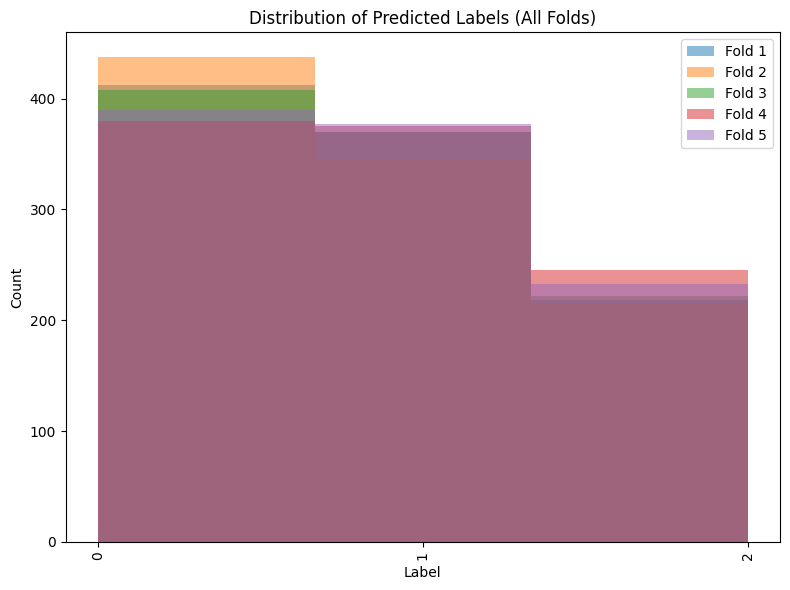

In [ ]:
# Load and preprocess data
train_df = pd.read_csv('train.csv', usecols=['text', 'aspect', 'label'])
test_df = pd.read_csv('test.csv', usecols=['text', 'aspect'])

# Define synonym replacement augmentation function
def synonym_replacement(words, n):
    augmented_words = []
    for word in words:
        if wordnet.synsets(word):
            syn = wordnet.synsets(word)[0]
            synonyms = [lemma.name().replace('_', ' ') for lemma in syn.lemmas()]
            if len(synonyms) > 1:
                augmented_words.append(np.random.choice(synonyms))
            else:
                augmented_words.append(word)
        else:
            augmented_words.append(word)
    return augmented_words

# Apply data augmentation
num_augmentations = 9
augmented_data = []
for _, row in train_df.iterrows():
    original_text = row['text']
    words = word_tokenize(original_text)

    augmented_texts = []
    for _ in range(num_augmentations):
        augmented_words = synonym_replacement(words.copy(), n=np.random.randint(1, 3))
        augmented_texts.append(' '.join(augmented_words))

    for augmented_text in augmented_texts:
        augmented_data.append({'text': augmented_text, 'aspect': row['aspect'], 'label': row['label']})

# Convert augmented data to a DataFrame
augmented_df = pd.DataFrame(augmented_data)

# Concatenate the original and augmented data
expanded_train_df = pd.concat([train_df, augmented_df], ignore_index=True)

# Shuffle the dataset
expanded_train_df = expanded_train_df.sample(frac=1).reset_index(drop=True)

# Convert labels to numerical values
label_encoder = LabelEncoder()
expanded_train_df['label'] = label_encoder.fit_transform(expanded_train_df['label'])

# Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store test predictions for each fold
test_predictions_per_fold = []

for fold, (train_index, val_index) in enumerate(skf.split(expanded_train_df, expanded_train_df['label'])):
    print(f"Fold {fold + 1}/{skf.n_splits}")

    train_fold = expanded_train_df.iloc[train_index]
    val_fold = expanded_train_df.iloc[val_index]

    # Train Word2Vec embeddings
    sentences = [text.split() + ['Aspect:' + aspect] for text, aspect in zip(train_fold['text'], train_fold['aspect'])]
    word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

    # Convert data to embeddings
    def text_to_embeddings(text, aspect):
        tokens = text.split() + ['Aspect:' + aspect]
        embeddings = [word2vec_model.wv[token] for token in tokens if token in word2vec_model.wv]
        if embeddings:
            return np.mean(embeddings, axis=0)
        else:
            return np.zeros(word2vec_model.vector_size)  # Use zero vectors for empty embeddings

    train_embeddings = np.array([text_to_embeddings(text, aspect) for text, aspect in zip(train_fold['text'], train_fold['aspect'])])
    val_embeddings = np.array([text_to_embeddings(text, aspect) for text, aspect in zip(val_fold['text'], val_fold['aspect'])])
    test_embeddings = np.array([text_to_embeddings(text, aspect) for text, aspect in zip(test_df['text'], test_df['aspect'])])

    # Define SentimentModel class
    class SentimentModel(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim):
            super(SentimentModel, self).__init__()
            self.fc1 = nn.Linear(input_dim, hidden_dim)
            self.fc2 = nn.Linear(hidden_dim, output_dim)

        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = self.fc2(x)
            return x

    # Training configuration
    input_dim = train_embeddings.shape[1]
    hidden_dim = 1024
    output_dim = len(label_encoder.classes_)
    model = SentimentModel(input_dim, hidden_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    criterion = nn.CrossEntropyLoss()

    # Convert embeddings and labels to PyTorch tensors
    train_embeddings = torch.tensor(train_embeddings, dtype=torch.float32)
    train_labels = torch.tensor(train_fold['label'].values, dtype=torch.long)
    val_embeddings = torch.tensor(val_embeddings, dtype=torch.float32)
    val_labels = torch.tensor(val_fold['label'].values, dtype=torch.long)
    test_embeddings = torch.tensor(test_embeddings, dtype=torch.float32)

    # Training loop
    num_epochs = 50
    batch_size = 1000
    for epoch in range(num_epochs):
        model.train()
        for batch_start in range(0, len(train_embeddings), batch_size):
            batch_end = batch_start + batch_size
            batch_embeddings = train_embeddings[batch_start:batch_end]
            batch_labels = train_labels[batch_start:batch_end]

            optimizer.zero_grad()
            outputs = model(batch_embeddings)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_outputs = model(val_embeddings)
        val_predictions = torch.argmax(val_outputs, dim=1)
        val_accuracy = torch.sum(val_predictions == val_labels).item() / len(val_labels)

        # Calculate precision, recall, and F1 score for validation data
        val_precision = precision_score(val_labels, val_predictions, average='weighted')
        val_recall = recall_score(val_labels, val_predictions, average='weighted')
        val_f1 = f1_score(val_labels, val_predictions, average='weighted')

        print(f"Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {val_accuracy:.4f}, "
              f"Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}, "
              f"Validation F1 Score: {val_f1:.4f}")

    # Inference on test data
    model.eval()
    test_outputs = model(test_embeddings)
    test_predictions = torch.argmax(test_outputs, dim=1)
    test_labels = test_predictions.numpy()
    test_predictions_per_fold.append(test_labels)

# Plot distribution of predicted labels for all folds
plt.figure(figsize=(8, 6))
for fold in range(skf.n_splits):
    test_labels = test_predictions_per_fold[fold]
    plt.hist(label_encoder.inverse_transform(test_labels), bins=len(label_encoder.classes_), alpha=0.5, label=f'Fold {fold+1}')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Predicted Labels (All Folds)')
plt.xticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_, rotation='vertical')
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\khans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\khans\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of BertForSequenceClassification were no

Epoch 1/5, Training Loss: 1.0917


Epoch 2/5: 100%|██████████| 113/113 [26:08<00:00, 13.88s/it]


Epoch 2/5, Training Loss: 1.0133


Epoch 3/5: 100%|██████████| 113/113 [2:13:51<00:00, 71.07s/it]    


Epoch 3/5, Training Loss: 0.7241


Epoch 4/5: 100%|██████████| 113/113 [20:51<00:00, 11.07s/it]


Epoch 4/5, Training Loss: 0.5242


Epoch 5/5: 100%|██████████| 113/113 [20:24<00:00, 10.84s/it]


Epoch 5/5, Training Loss: 0.3645
Validation Accuracy: 0.7225
Validation Precision: 0.7257
Validation Recall: 0.7225
Validation F1 Score: 0.7225


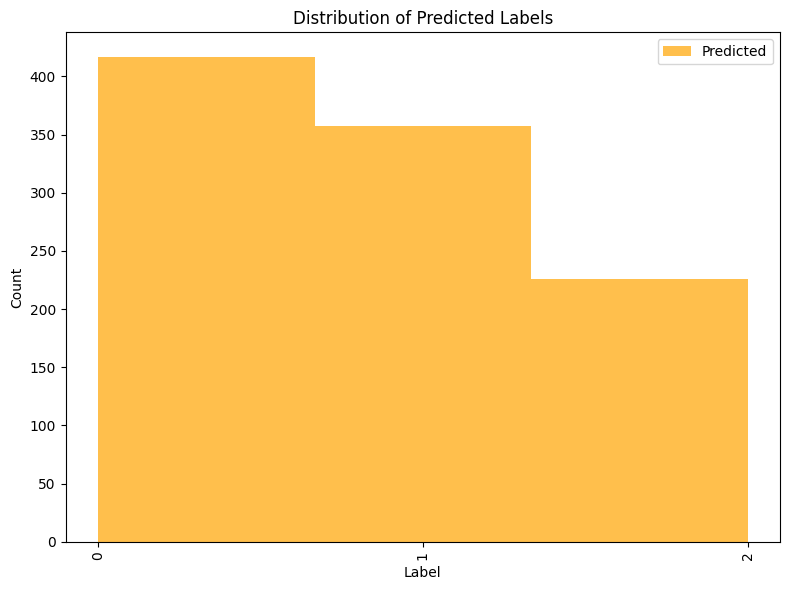

In [ ]:
# Load and preprocess data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Convert labels to numerical values
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['label'])

# Split train dataset into train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Create TensorDatasets for train, validation, and test
train_dataset = TensorDataset(
    torch.tensor(tokenizer.batch_encode_plus(train_df['text'].tolist(), padding='max_length', truncation=True, max_length=128)['input_ids']),
    torch.tensor(train_df['label'].tolist())
)
val_dataset = TensorDataset(
    torch.tensor(tokenizer.batch_encode_plus(val_df['text'].tolist(), padding='max_length', truncation=True, max_length=128)['input_ids']),
    torch.tensor(val_df['label'].tolist())
)
test_dataset = TensorDataset(
    torch.tensor(tokenizer.batch_encode_plus(test_df['text'].tolist(), padding='max_length', truncation=True, max_length=128)['input_ids'])
)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# Set up training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        input_ids, labels = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {np.mean(train_losses):.4f}")

# Validation
model.eval()
val_preds = []
val_labels = []
with torch.no_grad():
    for batch in val_loader:
        input_ids, labels = batch[0].to(device), batch[1].to(device)

        outputs = model(input_ids=input_ids).logits
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        val_preds.extend(preds)
        val_labels.extend(labels.cpu().numpy())

val_accuracy = accuracy_score(val_labels, val_preds)
val_precision = precision_score(val_labels, val_preds, average='weighted')
val_recall = recall_score(val_labels, val_preds, average='weighted')
val_f1 = f1_score(val_labels, val_preds, average='weighted')

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

# Inference on test data
test_preds = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch[0].to(device)

        outputs = model(input_ids=input_ids).logits
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        test_preds.extend(preds)

test_sentiments = label_encoder.inverse_transform(test_preds)

# Plot distribution of predicted labels
plt.figure(figsize=(8, 6))
plt.hist(test_sentiments, bins=len(label_encoder.classes_), alpha=0.7, color='orange', label='Predicted')

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Predicted Labels')
plt.xticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_, rotation='vertical')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
class SentimentAnalysisBERT:
    def __init__(self, train_csv, test_csv):
        self.train_csv = train_csv
        self.test_csv = test_csv
        self.label_encoder = LabelEncoder()
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
        self.optimizer = AdamW(self.model.parameters(), lr=2e-5)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.train_loader = None
        self.val_loader = None
        self.test_loader = None
        self.lemmatizer = WordNetLemmatizer()

    def preprocess_text(self, text):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        tokens = word_tokenize(text)
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
        tokens = [self.lemmatizer.lemmatize(word) for word in tokens]
        preprocessed_text = ' '.join(tokens)
        return preprocessed_text

    def k_fold_cross_validation(self, train_df, num_epochs=3):
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        for fold, (train_idx, val_idx) in enumerate(kf.split(train_df['text'], train_df['label']), 1):
            train_data = train_df.iloc[train_idx]
            val_data = train_df.iloc[val_idx]

            train_loader = DataLoader(self.create_dataset(train_data), batch_size=32, shuffle=True)
            val_loader = DataLoader(self.create_dataset(val_data), batch_size=64)

            # Move model to the same device as the tensors
            self.model.to(self.device)

            print(f"Fold {fold}:")
            for epoch in range(num_epochs):
                print(f"Epoch {epoch+1}/{num_epochs}")

                # Move the model to the same device as the tensors
                self.model.to(self.device)

                train_loss = self.train(train_loader)
                print(f"Training Loss: {train_loss:.4f}")

                val_accuracy, val_precision, val_recall, val_f1 = self.evaluate(val_loader)
                print(f"Validation Accuracy: {val_accuracy:.4f}")
                print(f"Validation Precision: {val_precision:.4f}")
                print(f"Validation Recall: {val_recall:.4f}")
                print(f"Validation F1 Score: {val_f1:.4f}")
                print()

    def synonym_augmentation(self, text, num_synonyms=1):
        tokens = word_tokenize(text)
        augmented_texts = [text]

        for _ in range(num_synonyms):
            for idx, token in enumerate(tokens):
                synonyms = self.get_synonyms(token)
                if synonyms:
                    new_token = np.random.choice(synonyms)
                    augmented_tokens = tokens[:idx] + [new_token] + tokens[idx+1:]
                    augmented_texts.append(' '.join(augmented_tokens))

        return augmented_texts

    def get_synonyms(self, word):
        synonyms = []
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                synonyms.append(lemma.name())
        return list(set(synonyms))

    def load_and_preprocess_data(self):
        train_df = pd.read_csv(self.train_csv)
        test_df = pd.read_csv(self.test_csv)

        train_df['text'] = train_df['text'].apply(self.preprocess_text)
        test_df['text'] = test_df['text'].apply(self.preprocess_text)

        train_df['label'] = self.label_encoder.fit_transform(train_df['label']) - train_df['label'].min()

        train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

        self.train_loader = DataLoader(self.create_dataset(train_df), batch_size=32, shuffle=True)
        self.val_loader = DataLoader(self.create_dataset(val_df), batch_size=64)
        self.test_loader = DataLoader(self.create_test_dataset(test_df), batch_size=64)

    def create_dataset(self, df):
        input_ids = torch.tensor(self.tokenizer.batch_encode_plus(df['text'].tolist(), padding='max_length', truncation=True, max_length=128)['input_ids'])
        labels = torch.tensor(df['label'].tolist())
        return TensorDataset(input_ids, labels)

    def create_test_dataset(self, df):
        input_ids = torch.tensor(self.tokenizer.batch_encode_plus(df['text'].tolist(), padding='max_length', truncation=True, max_length=128)['input_ids'])
        return TensorDataset(input_ids)

    def train(self, data_loader):
        self.model.train()
        train_losses = []
        for batch in tqdm(data_loader, desc='Training'):
            input_ids, labels = batch[0].to(self.device), batch[1].to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(input_ids=input_ids).logits
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            train_losses.append(loss.item())

        return np.mean(train_losses)

    def evaluate(self, data_loader):
        self.model.eval()
        val_preds = []
        val_labels = []
        with torch.no_grad():
            for batch in data_loader:
                input_ids, labels = batch[0].to(self.device), batch[1].to(self.device)

                outputs = self.model(input_ids=input_ids).logits
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                val_preds.extend(preds)
                val_labels.extend(labels.cpu().numpy())

        val_accuracy = accuracy_score(val_labels, val_preds)
        val_precision = precision_score(val_labels, val_preds, average='weighted')
        val_recall = recall_score(val_labels, val_preds, average='weighted')
        val_f1 = f1_score(val_labels, val_preds, average='weighted')

        return val_accuracy, val_precision, val_recall, val_f1

    def infer_test_data(self):
        self.model.eval()
        test_preds = []
        with torch.no_grad():
            for batch in self.test_loader:
                input_ids = batch[0].to(self.device)

                outputs = self.model(input_ids=input_ids).logits
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                test_preds.extend(preds)

        test_sentiments = self.label_encoder.inverse_transform(test_preds)

        plt.figure(figsize=(8, 6))
        plt.hist(test_sentiments, bins=len(self.label_encoder.classes_), alpha=0.7, color='orange', label='Predicted')

        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.title('Distribution of Predicted Labels')
        plt.xticks(np.arange(len(self.label_encoder.classes_)), self.label_encoder.classes_, rotation='vertical')
        plt.legend()
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    bert_sentiment = SentimentAnalysisBERT('train.csv', 'test.csv')
    bert_sentiment.load_and_preprocess_data()
    bert_sentiment.k_fold_cross_validation(train_df, num_epochs=1)
    bert_sentiment.infer_test_data()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\khans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


KeyError: 'text'

In [ ]:
import torch
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

class AspectSentimentBERT:
    def __init__(self, train_csv, test_csv):
        self.train_csv = train_csv
        self.test_csv = test_csv
        self.label_encoder = LabelEncoder()
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
        self.optimizer = AdamW(self.model.parameters(), lr=2e-5)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.train_loader = None
        self.val_loader = None
        self.test_loader = None
        self.lemmatizer = WordNetLemmatizer()

    def preprocess_text(self, text):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        tokens = word_tokenize(text)
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
        tokens = [self.lemmatizer.lemmatize(word) for word in tokens]
        preprocessed_text = ' '.join(tokens)
        return preprocessed_text

    def k_fold_cross_validation(self, train_df, num_epochs=3):
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        for fold, (train_idx, val_idx) in enumerate(kf.split(train_df['text'], train_df['label']), 1):
            train_data = train_df.iloc[train_idx]
            val_data = train_df.iloc[val_idx]

            train_loader = DataLoader(self.create_dataset(train_data), batch_size=32, shuffle=True)
            val_loader = DataLoader(self.create_dataset(val_data), batch_size=64)

            # Move model to the same device as the tensors
            self.model.to(self.device)

            print(f"Fold {fold}:")
            for epoch in range(num_epochs):
                print(f"Epoch {epoch+1}/{num_epochs}")

                # Move the model to the same device as the tensors
                self.model.to(self.device)

                train_loss = self.train(train_loader)
                print(f"Training Loss: {train_loss:.4f}")

                val_accuracy, val_precision, val_recall, val_f1 = self.evaluate(val_loader)
                print(f"Validation Accuracy: {val_accuracy:.4f}")
                print(f"Validation Precision: {val_precision:.4f}")
                print(f"Validation Recall: {val_recall:.4f}")
                print(f"Validation F1 Score: {val_f1:.4f}")
                print()

    def load_and_preprocess_data(self):
        train_df = pd.read_csv(self.train_csv)
        test_df = pd.read_csv(self.test_csv)

        train_df['text'] = train_df['text'].apply(self.preprocess_text)
        test_df['text'] = test_df['text'].apply(self.preprocess_text)

        train_df['label'] = self.label_encoder.fit_transform(train_df['label'])

        train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

        self.train_loader = DataLoader(self.create_dataset(train_df), batch_size=32, shuffle=True)
        self.val_loader = DataLoader(self.create_dataset(val_df), batch_size=64)
        self.test_loader = DataLoader(self.create_test_dataset(test_df), batch_size=64)

    def create_dataset(self, df):
        input_ids = torch.tensor(self.tokenizer.batch_encode_plus(df['text'].tolist(), padding='max_length', truncation=True, max_length=128)['input_ids'])
        labels = torch.tensor(df['label'].tolist())
        return TensorDataset(input_ids, labels)

    def create_test_dataset(self, df):
        input_ids = torch.tensor(self.tokenizer.batch_encode_plus(df['text'].tolist(), padding='max_length', truncation=True, max_length=128)['input_ids'])
        return TensorDataset(input_ids)

    def train(self, data_loader):
        self.model.train()
        train_losses = []
        for batch in data_loader:
            input_ids, labels = batch[0].to(self.device), batch[1].to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(input_ids=input_ids).logits
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            train_losses.append(loss.item())

        return np.mean(train_losses)

    def evaluate(self, data_loader):
        self.model.eval()
        val_preds = []
        val_labels = []
        with torch.no_grad():
            for batch in data_loader:
                input_ids, labels = batch[0].to(self.device), batch[1].to(self.device)

                outputs = self.model(input_ids=input_ids).logits
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                val_preds.extend(preds)
                val_labels.extend(labels.cpu().numpy())

        val_accuracy = accuracy_score(val_labels, val_preds)
        val_precision = precision_score(val_labels, val_preds, average='weighted')
        val_recall = recall_score(val_labels, val_preds, average='weighted')
        val_f1 = f1_score(val_labels, val_preds, average='weighted')

        return val_accuracy, val_precision, val_recall, val_f1

    def infer_test_data(self):
        self.model.eval()
        test_preds = []
        with torch.no_grad():
            for batch in self.test_loader:
                input_ids = batch[0].to(self.device)

                outputs = self.model(input_ids=input_ids).logits
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                test_preds.extend(preds)

        test_sentiments = self.label_encoder.inverse_transform(test_preds)

        plt.figure(figsize=(8, 6))
        plt.hist(test_sentiments, bins=len(self.label_encoder.classes_), alpha=0.7, color='orange', label='Predicted')

        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.title('Distribution of Predicted Labels')
        plt.xticks(np.arange(len(self.label_encoder.classes_)), self.label_encoder.classes_, rotation='vertical')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def predict_sentiment_and_aspect(self, review_text):
        # Preprocess the input review
        preprocessed_text = self.preprocess_text(review_text)

        # Tokenize and convert to tensor
        input_ids = torch.tensor(self.tokenizer.batch_encode_plus([preprocessed_text], padding='max_length', truncation=True, max_length=128)['input_ids']).to(self.device)

        # Set model to evaluation mode
        self.model.eval()

        with torch.no_grad():
            # Get model predictions
            outputs = self.model(input_ids=input_ids).logits
            sentiment_pred = torch.argmax(outputs, dim=1).cpu().numpy()[0]

        # Decode the sentiment label
        sentiment_label = self.label_encoder.inverse_transform([sentiment_pred])[0]

        return sentiment_label, preprocessed_text  # Return the predicted sentiment and preprocessed text

if __name__ == "__main__":
    aspect_sentiment_bert = AspectSentimentBERT('train.csv', 'test.csv')
    aspect_sentiment_bert.load_and_preprocess_data()
    aspect_sentiment_bert.k_fold_cross_validation(train_df, num_epochs=1)
    aspect_sentiment_bert.infer_test_data()

    # Example usage of predict_sentiment_and_aspect
    input_review = "The food at this restaurant is excellent!"
    predicted_sentiment, preprocessed_text = aspect_sentiment_bert.predict_sentiment_and_aspect(input_review)

    print(f"Predicted Sentiment: {predicted_sentiment}")
    print(f"Preprocessed Text: {preprocessed_text}")




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\khans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


KeyError: 'text'

In [ ]:
    # Example usage of predict_sentiment_and_aspect
    input_review = "The food at this restaurant is excellent!"
    predicted_sentiment, preprocessed_text = aspect_sentiment_bert.predict_sentiment_and_aspect(input_review)

    print(f"Predicted Sentiment: {predicted_sentiment}")
    print(f"Preprocessed Text: {preprocessed_text}")

Predicted Sentiment: 2
Preprocessed Text: food restaurant excellent


In [ ]:

    # List of reviews
    review_list = [
        "The food at this restaurant is excellent!",
        "The service was terrible, but the food was good.",
        "I had a neutral experience at this place.",
        "The ambiance of the restaurant is cozy and inviting.",
        "I will never go back to this place. It was a terrible experience.",
        "The staff was friendly and attentive, and the food was delicious.",
        "The prices are too high for the quality of food they serve.",
        "I had a mixed experience. The food was great, but the service was slow.",
        "The restaurant was clean and well-maintained.",
        "The food tasted awful, and I won't recommend this place to anyone."

    ]

    # Predict sentiments and aspects for each review
    for review_text in review_list:

        predicted_sentiment, preprocessed_text = aspect_sentiment_bert.predict_sentiment_and_aspect(review_text)
        print(f"Review: {review_text}")
        print(f"Predicted Sentiment: {predicted_sentiment}")
        print(f"Preprocessed Text: {preprocessed_text}\n")

Review: The food at this restaurant is excellent!
Predicted Sentiment: 2
Preprocessed Text: food restaurant excellent

Review: The service was terrible, but the food was good.
Predicted Sentiment: 0
Preprocessed Text: service terrible food good

Review: I had a neutral experience at this place.
Predicted Sentiment: 2
Preprocessed Text: neutral experience place

Review: The ambiance of the restaurant is cozy and inviting.
Predicted Sentiment: 2
Preprocessed Text: ambiance restaurant cozy inviting

Review: I will never go back to this place. It was a terrible experience.
Predicted Sentiment: 0
Preprocessed Text: never go back place terrible experience

Review: The staff was friendly and attentive, and the food was delicious.
Predicted Sentiment: 2
Preprocessed Text: staff friendly attentive food delicious

Review: The prices are too high for the quality of food they serve.
Predicted Sentiment: 0
Preprocessed Text: price high quality food serve

Review: I had a mixed experience. The food 